In [1]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import arviz as az

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

from datetime import date
import os

## Simulate Data

In [2]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

In [3]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

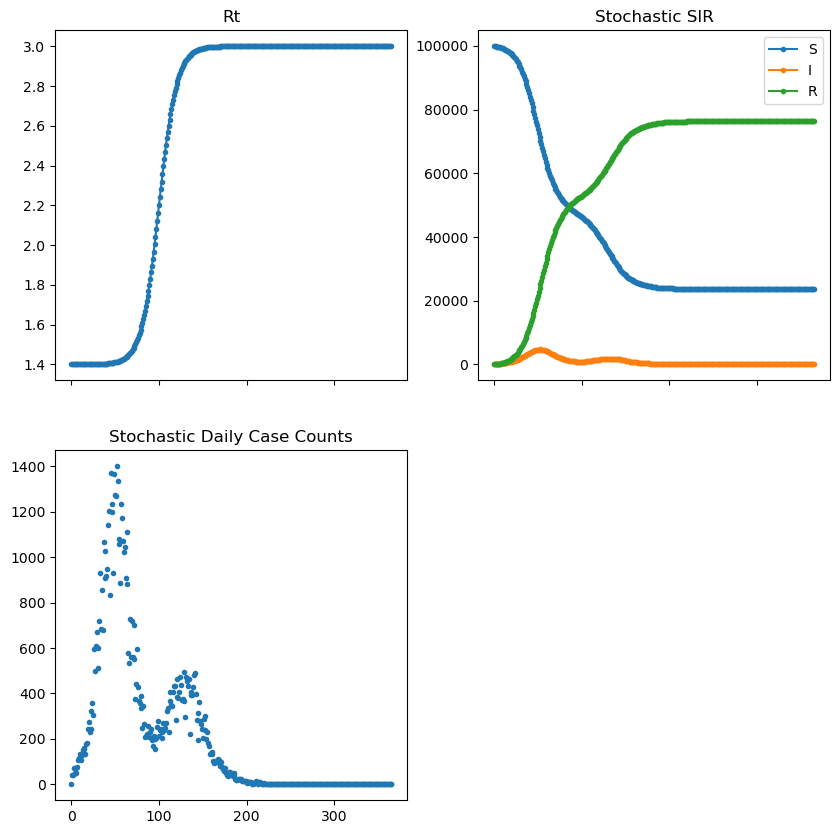

In [4]:
data.plot_all()

## Metropolis Hastings

0. Initialize $\theta_0 \sim p(\theta)$
1. For each iteration `t=0:num_burn_in+num_draws`
    * Generate candidate $\theta^\prime \sim \mathcal{N}(\theta_t, \sigma=2)$ **fixed step size**
    * Acceptance ratio $r = \min\left(1, \frac{p(\theta^\prime)p(x|\theta^\prime)}{p(\theta_t)p(x|\theta_t)}\right) $
        - Equivalently in log space
         $
         \log(r) = \min\left(0, \log p(\theta^\prime) + \log p(x|\theta^\prime) - \log p(\theta_t) - \log p(x|\theta_t)\right)
         $
    * Accept/ reject
        - $u \sim U[0,1]$
        - If $\log(u) \leq \log(r)$, then *accept*, i.e., $\theta_{t+1} = \theta^\prime$
        - Otherwise $\log(u) > \log(r)$, then *reject*, i.e., $\theta_{t+1} = \theta_{t}$

In [168]:
ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'rt_0',
      'rt_1',
      'k',
      'midpoint',
      'I0'
    ]
)

In [228]:
accept_list = {
    'rt_0': [1,0],
    'rt_1': [1,0],
    'k': [1,1],
    'midpoint': [1,1],
    'I0': [1,1]
}
# accept_array = np.ndarray(list(accept_list.values()))


array([0.5, 0.5, 1. , 1. , 1. ])

In [5]:
## unset seed
np.random.seed()

In [6]:
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [7]:
n_t = 365
t = np.arange(n_t)
t_I = 4.
N = 100_000



In [55]:
import model_metropolis_hastings
importlib.reload(model_metropolis_hastings)

sir_model = model.SIR_model(data)

likelihood = {
    'dist': 'normal',
}
prior = {
    'rt_0':{
        'dist': uniform,
        'lower': 1.,
        'upper': 4.,
    },
    'rt_1':{
        'dist': uniform,
        'lower': 1.5,
        'upper': 4.,
    },
    'k':{
        'dist': uniform,
        'lower': 0.01,
        'upper': 2,
    },
    'midpoint':{
        'dist': randint,
        'lower': 30,
        'upper': 200,
    },
    'I0':{
        'dist': poisson,
        'mu': 50,
    },
}

n_samples = 50000
n_tune = 10000

params = []
for k,v in prior.items():
    if v['dist'] != "constant":
        params.append(k)

today = date.today() 
name = f"custom_MH_likelihood_{likelihood['dist']}"
path = os.path.abspath(f'../data/{today}_{name}')

print(name)

In [354]:
def halfcauchy(x,beta):
    if x < 0:
        raise ValueError("x must be positive")
    if beta < 0:
        raise ValueError("beta must be positive")
        
    return 2/(np.pi*beta*(1+(x/beta)**2))

def forward(x, a, b):
    u = (x - a)/(b-a)
    return np.log(u / (1 - u))

def backward(y, a, b):
    return a + (b-a)/(1 + np.exp(-y))


index_map = {
    'rt_0': 0,
    'rt_1': 1,
    'k': 2,
    'midpoint': 3,
    'I0': 4,
}

def check_one_bound(new_draw, var):
    index = index_map[var]
    if index == 4:
        return new_draw > 0
    else:
        return new_draw > prior[var]['lower'] and new_draw < prior[var]['upper']
    
def draw_sample_elemwise(draw, var, scales):
    index = index_map[var]
    
    scale = scales[index]
    
    bounds_good = False
    
    while(not bounds_good):
        val = norm(loc=draw[var], scale=scale).rvs(1)[0]
        bounds_good = check_one_bound(val, var)
    
    if index == 3 or index == 4:
        val = int(val)
    
    return val

def draw_sample_elemwise_nobound(draw, var, scale=2):
    index = index_map[var]
    val = norm(loc=draw[var], scale=scale).rvs(1)[0]
    
    return val

def sample_new(rt_0, rt_1, k, midpoint, I0, scale=[0.1, 0.1, 0.01, 2, 2]):
    
    bounds_good = False
    
    while(not bounds_good):
        new_draw = multivariate_normal(mean=np.array([rt_0, rt_1, k, midpoint, I0]), cov=np.diag(scale)).rvs(1)
        bounds_good = check_bounds(new_draw)
    
    return new_draw[0], new_draw[1], new_draw[2], int(new_draw[3]), int(new_draw[4])

def sample_new_midpoint(midpoint, scale=2):
    new_draw = norm(loc=midpoint, scale=scale).rvs(1)
    return int(new_draw[0])

def random_coin(p):
    unif = np.random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

def log_random_coin(logp):
    unif = np.random.uniform(0,1)
    if np.log(unif)>=logp:
        return False
    else:
        return True

def integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0, n_t):
    t = np.arange(365)
    rt = rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*(t - midpoint)))
    beta = rt / t_I
    S = np.array([S0])
    Ir = np.array([I0])
    R = np.array([0])
    i = np.array([0])
    for t in range(n_t):
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/N)
        dIR = np.random.poisson(Ir[t]/t_I)

        S_new = np.clip(S[t]-dSI, 0, N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, N)
        R_new = np.clip(R[t]+dIR, 0, N)

        S = np.append(S, S_new)
        Ir = np.append(Ir, I_new)
        R = np.append(R, R_new)
        i = np.append(i, dSI)

    return S, Ir, R, i


def logprior_prob(rt_0, rt_1, k, midpoint, I0):
    p_rt_0 = uniform(loc=prior['rt_0']['lower'], scale=(prior['rt_0']['upper'] - prior['rt_0']['lower'])).logpdf(rt_0)
    p_rt_1 = uniform(loc=prior['rt_1']['lower'], scale=(prior['rt_1']['upper'] - prior['rt_1']['lower'])).logpdf(rt_1)
    p_k = uniform(loc=prior['k']['lower'], scale=(prior['k']['upper'] - prior['k']['lower'])).logpdf(k)
    p_midpoint = randint(low=prior['midpoint']['lower'], high=prior['midpoint']['upper']).logpmf(midpoint)
    p_I0 = poisson(prior['I0']['mu']).logpmf(I0)
    
    prob = np.sum([p_rt_0, p_rt_1, p_k, p_midpoint, p_I0])
    
    return prob

def loglike_prob(i, data=data.i):
    # prob = multivariate_normal(mean=i[1:], cov=np.diag((1+0.2*i[1:])**2)).logpdf(data[1:])
    prob = norm(loc=i[1:], scale=np.abs(1+0.2*i[1:])).logpdf(data[1:])
    # prob = norm(loc=i[1:200], scale=np.abs(1+0.2*i[1:])).logpdf(data[1:200])
    prob = np.sum(prob)
    return prob

def tune(scale, acc_rate):
    """
    Tunes the scaling parameter for the proposal distribution
    according to the acceptance rate over the last tune_interval:

    Rate    Variance adaptation
    ----    -------------------
    <0.001        x 0.1
    <0.05         x 0.5
    <0.2          x 0.9
    >0.5          x 1.1
    >0.75         x 2
    >0.95         x 10

    """
    return scale * np.where(
        acc_rate < 0.001,
        # reduce by 90 percent
        0.1,
        np.where(
            acc_rate < 0.05,
            # reduce by 50 percent
            0.5,
            np.where(
                acc_rate < 0.2,
                # reduce by ten percent
                0.9,
                np.where(
                    acc_rate > 0.95,
                    # increase by factor of ten
                    10.0,
                    np.where(
                        acc_rate > 0.75,
                        # increase by double
                        2.0,
                        np.where(
                            acc_rate > 0.5,
                            # increase by ten percent
                            1.1,
                            # Do not change
                            1.0,
                        ),
                    ),
                ),
            ),
        ),
    )
    
    
def metropolis_hastings(burn_in, draws, tune_interval=100, sample_elemwise=False):
    # things to track
    i_list = []
    chain = []
    like_list = []
    prior_list = []
    accept_list = {
        'rt_0': [1],
        'rt_1': [1],
        'k': [1],
        'midpoint': [1],
        'I0': [1]
    }
    accept_prob_list = []
    scale_list = []
    
    # rt_0 = prior['rt_0']['dist'](loc=prior['rt_0']['lower'], scale=(prior['rt_0']['upper'] - prior['rt_0']['lower'])).rvs(1)[0]
    # rt_1 = uniform(loc=prior['rt_1']['lower'], scale=(prior['rt_1']['upper'] - prior['rt_1']['lower'])).rvs(1)[0]
    # k = uniform(loc=prior['k']['lower'], scale=(prior['k']['upper'] - prior['k']['lower'])).rvs(1)[0]
    # midpoint = randint(low=prior['midpoint']['lower'], high=prior['midpoint']['upper']).rvs(1)[0]
    # I0 = poisson(prior['I0']['mu']).rvs(1)[0]
    
    rt_0 = data.rt_0
    rt_1 = data.rt_1
    k = data.k
    midpoint = randint(low=prior['midpoint']['lower'], high=prior['midpoint']['upper']).rvs(1)[0]
    I0 = data.I0
    
    S0 = N - I0
    
    current = {
        "rt_0": rt_0,
        "rt_1": rt_1,
        "k": k,
        "midpoint": midpoint,
        "I0": I0,
    }
    chain.append(current.copy())
    
    accept = 1
    scales = np.array([0.1, 0.1, 0.01, 2, 2])
    scale_list.append(scales)

    from tqdm import tqdm
    
    if sample_elemwise:
        for j in tqdm(range(int((burn_in+draws)/5))):
            if j > 0 and j*5 % tune_interval == 0:
                acc_rate = np.mean(np.array(list(accept_list.values())), axis=1)
                scales = tune(scales, acc_rate)
            
            params = ['rt_0', 'rt_1', 'k', 'midpoint', 'I0']
            np.random.shuffle(params)
                
            for param in params:
                
                if accept == 1:
                    _, _, _, i = integrate(t_I=t_I, N=N, S0=N - current['I0'], n_t=n_t, **current.copy())

                i_list.append(i)

                logprior = logprior_prob(**current)
                loglike = loglike_prob(i)
                curr_prob = logprior + loglike
                
                new_draw = current.copy()
                val = draw_sample_elemwise(new_draw, param, scales)
                new_draw[param] = val
                
                S0_new = N - new_draw['I0']
                
                _, _, _, i_new = integrate(t_I=t_I, N=N, S0=S0_new, n_t=n_t, **new_draw.copy())

                logprior_new = logprior_prob(**new_draw.copy())
                loglike_new = loglike_prob(i_new)
                move_prob = logprior_new + loglike_new

                logacceptance = np.minimum(move_prob - curr_prob, 0.)
                accept_prob_list.append(logacceptance)

                if log_random_coin(logacceptance):
                    current[param] = val
                    accept = 1
                    accept_list[param].append(accept)
                    like_list.append(loglike_new)
                    prior_list.append(logprior_new)
                else:
                    accept = 0
                    accept_list[param].append(accept)
                    like_list.append(loglike)
                    prior_list.append(logprior)
            
                chain.append(current.copy())
    
    else:
        for iter in tqdm(range(burn_in+draws)):

            if accept == 1:
                _, _, _, i = integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0=N-I0, n_t=n_t)

            i_list.append(i)

            logprior = logprior_prob(rt_0, rt_1, k, midpoint, I0)
            loglike = loglike_prob(i)
            curr_prob = logprior + loglike

            rt_0_new, rt_1_new, k_new, midpoint_new, I0_new = sample_new(rt_0, rt_1, k, midpoint, I0)
            # midpoint_new = sample_new_midpoint(midpoint)
            S0 = N - I0_new
            _, _, _, i_new = integrate(rt_0_new, rt_1_new, k_new, midpoint_new, I0_new, t_I, N, S0, n_t)

            logprior_new = logprior_prob(rt_0_new, rt_1_new, k_new, midpoint_new, I0_new)
            loglike_new = loglike_prob(i_new)
            move_prob = logprior_new + loglike_new

            # print(f"proposed: {midpoint_new}, log prior: {prior_new}, like_new: {like_new}")

            logacceptance = np.minimum(move_prob - curr_prob, 0.)
            accept_prob_list.append(logacceptance)

            if log_random_coin(logacceptance):
                current = {
                    "rt_0": rt_0,
                    "rt_1": rt_1,
                    "k": k,
                    "midpoint": midpoint_new,
                    "I0": I0,
                }
                rt_0 = rt_0_new
                rt_1 = rt_1_new
                k = k_new
                midpoint = midpoint_new
                I0 = I0_new
                accept = 1
                accept_list.append(accept)
                like_list.append(loglike_new)
                prior_list.append(logprior_new)
            else:
                accept = 0
                accept_list.append(accept)
                like_list.append(loglike)
                prior_list.append(logprior)

            chain.append(current)

    return chain[burn_in:], chain[:burn_in], accept_list, accept_prob_list, np.array(i_list), like_list, prior_list, scale_list

In [355]:
trace, burn_in, accept_list, accept_prob_list, i, like_list, prior_list, scale_list = metropolis_hastings(burn_in=1000, draws=5000, sample_elemwise=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [02:05<00:00,  9.58it/s]


In [356]:
np.mean(np.array(list(accept_list.values())), axis=1)

array([0.1623647 , 0.17651957, 0.17735221, 0.17818485, 0.16402998])

In [357]:
burn_in_df = pd.DataFrame(burn_in)
df = pd.DataFrame(trace)

In [358]:
def summary(df, vars):
    mean_df = pd.DataFrame(df[vars].mean())
    ci_df = []
    for var in vars:
        ci = az.hdi(np.array(df[var]), alpha=0.94)
        ci_df.append(ci)
    ci_df = pd.DataFrame(ci_df)

    summary_df = pd.DataFrame()
    summary_df['mean'] = mean_df
    summary_df[['HDI 3%', 'HDI 94%']] = ci_df.values
    summary_df['truth'] = [true_params[var] for var in vars]
    
    return summary_df

In [359]:
vars = ['rt_0', 'rt_1', 'k', 'midpoint', 'I0']
summary(df, vars)

,mean,HDI 3%,HDI 94%,truth
rt_0,1.412802,1.326618,1.436791,1.4
rt_1,3.445010,3.138175,3.716819,3.0
k,0.076261,0.068170,0.078728,0.1
midpoint,95.631474,76.000000,118.000000,100.0
I0,55.041592,28.000000,92.000000,100.0


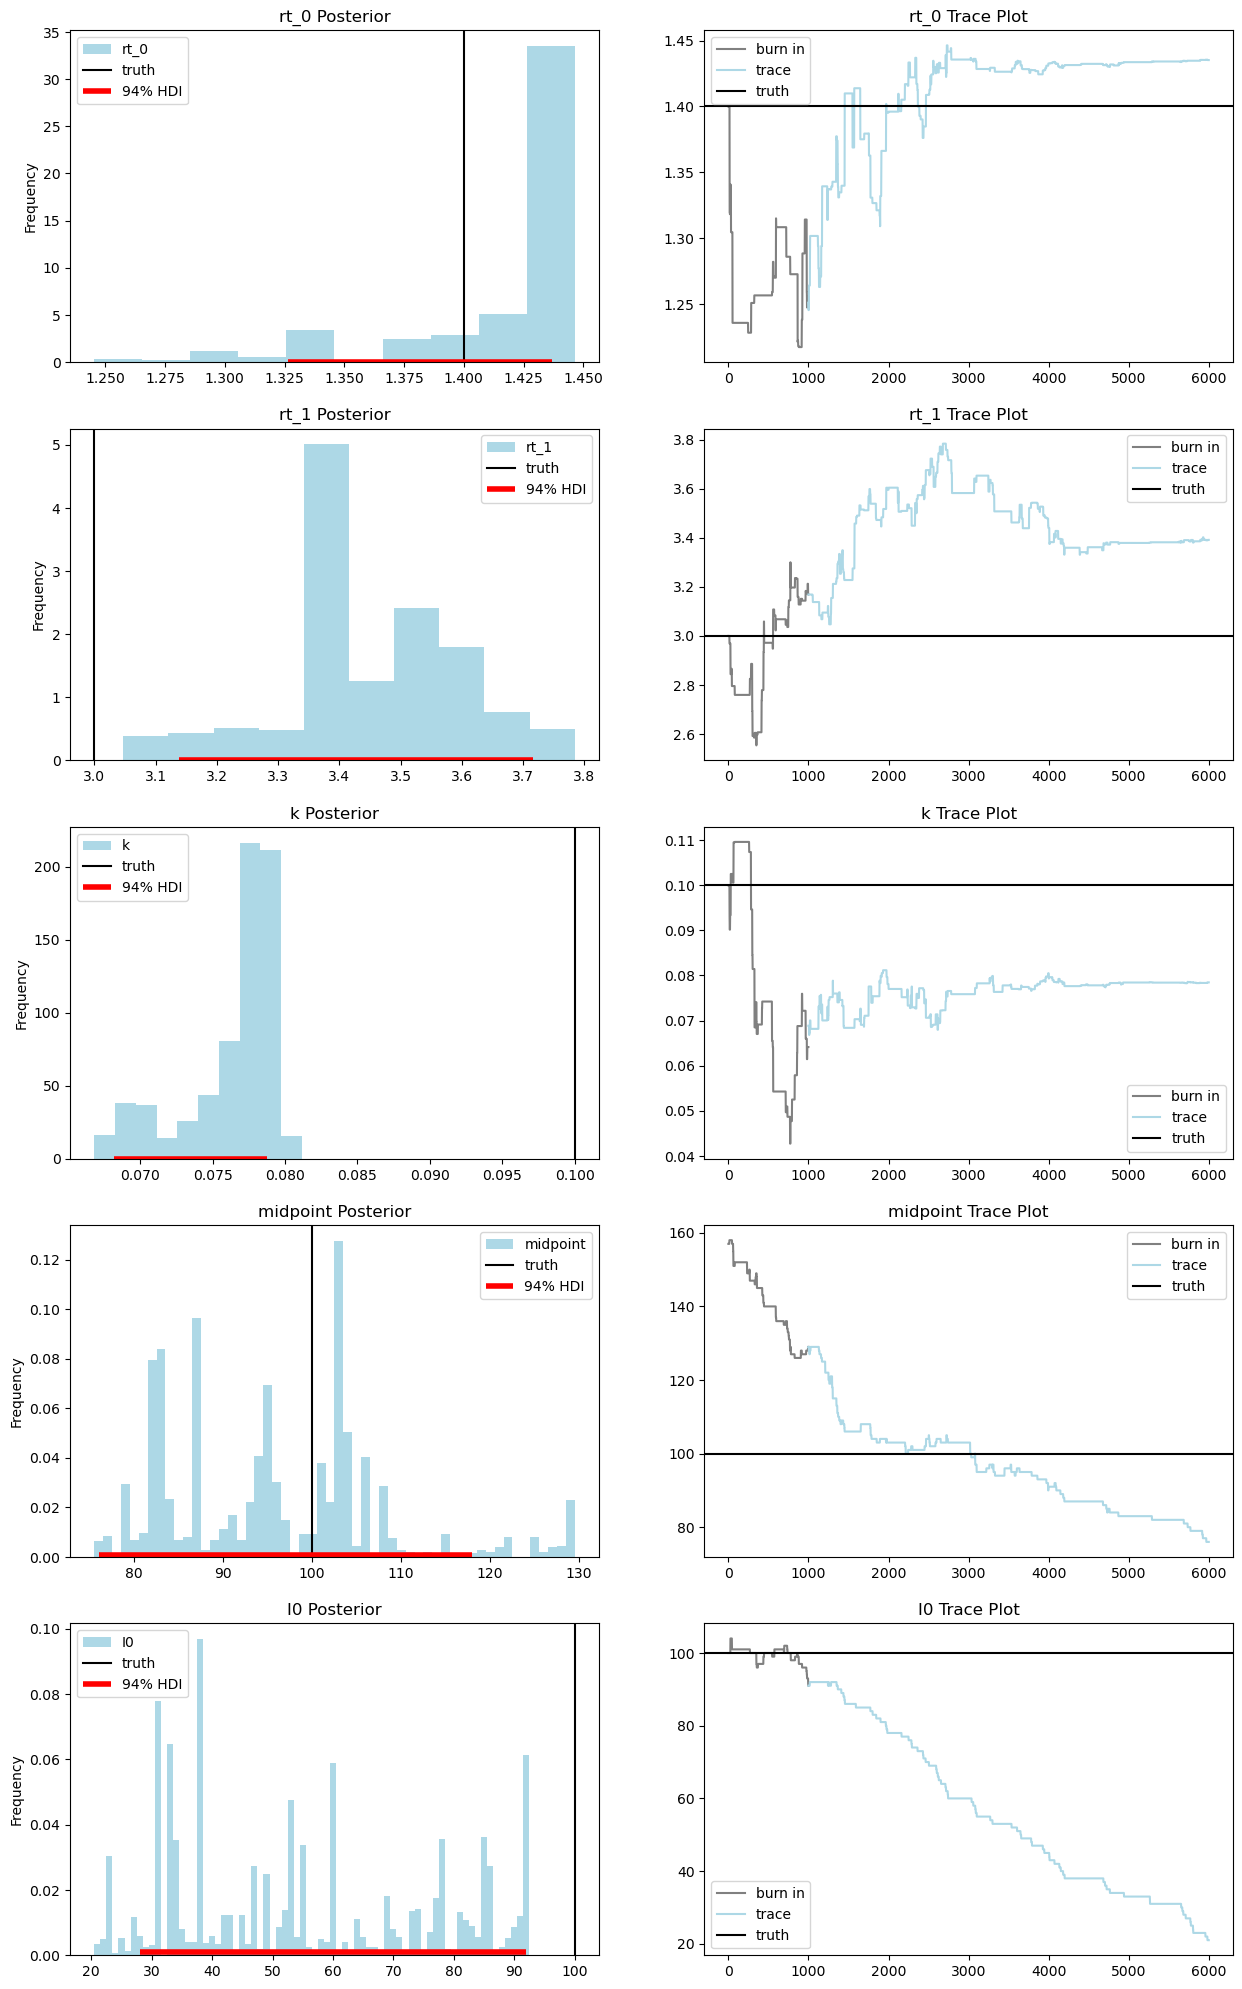

In [360]:
def compute_bins(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    
    bins = np.arange(left_of_first_bin, right_of_last_bin + d, d)
    
    return bins

def compute_ci(data):
    return az.hdi(np.array(data), alpha=0.94)

def plot_post(var, ax, bins=False):
    
    ci = compute_ci(df[var])
    if bins:
        bins = compute_bins(df[var])
        df[var].plot.hist(ax=ax, bins=bins, density=True, color='lightblue')
    else:
        df[var].plot.hist(ax=ax, density=True, color='lightblue')
    ax.axvline(x = true_params[var], color = 'black', alpha=1, linestyle = '-', label='truth')
    ax.hlines(y = 0.001, xmin = ci[0], xmax = ci[1], color='r', linewidth=4, label='94% HDI')
    ax.set_title(f'{var} Posterior')
    ax.legend()

def plot_trace(var, ax):
    ax.plot(np.arange(0,1000), burn_in_df[var], color='grey', label = 'burn in')
    ax.plot(np.arange(999,6000), df[var], color='lightblue', label = 'trace')
    ax.axhline(y = true_params[var], color = 'black', alpha=1, linestyle = '-', label='truth')
    ax.set_title(f'{var} Trace Plot')
    ax.legend()

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,25))

# rt_0
plot_post('rt_0', ax=ax[0][0])
plot_trace('rt_0', ax=ax[0][1])


# rt_1
plot_post('rt_1', ax=ax[1][0])
plot_trace('rt_1', ax=ax[1][1])

# k
plot_post('k', ax=ax[2][0])
plot_trace('k', ax=ax[2][1])

# midpoint
plot_post('midpoint', ax=ax[3][0], bins=True)
plot_trace('midpoint', ax=ax[3][1])

# I0
plot_post('I0', ax=ax[4][0], bins=True)
plot_trace('I0', ax=ax[4][1])

In [361]:
trace[2000]

{'rt_0': 1.435595604026774,
 'rt_1': 3.582802155826747,
 'k': 0.07586119940257338,
 'midpoint': 103,
 'I0': 60}

In [346]:
S, Ir, R, i2000 = integrate(t_I=t_I, N=N, S0 = N - trace[2000]['I0'], n_t = n_t, **trace[2000])
i2000

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [348]:
Ir

array([7, 5, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

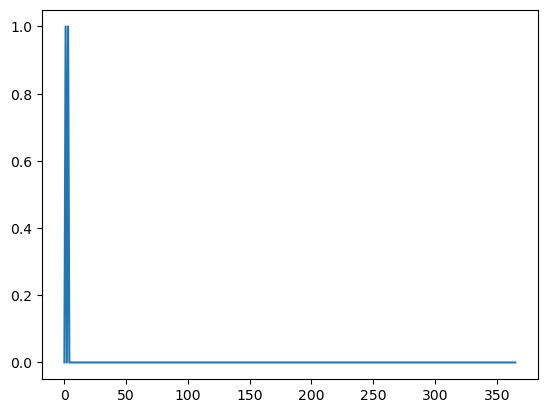

In [352]:
plt.plot(i2000)

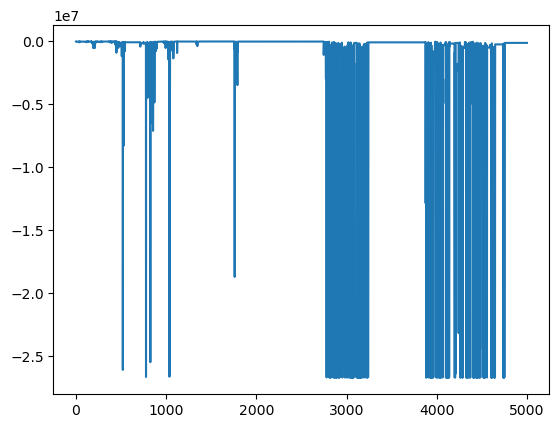

In [250]:
plt.plot(like_list[1000:])

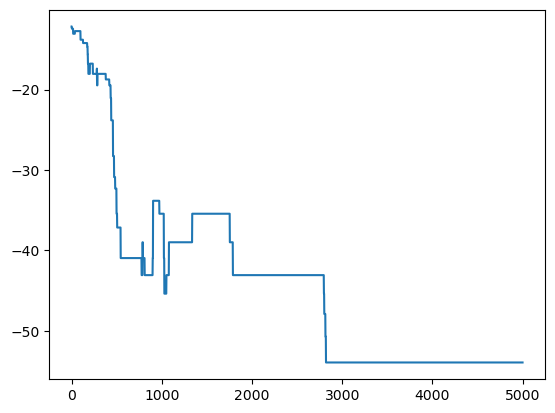

In [251]:
plt.plot(prior_list[1000:])

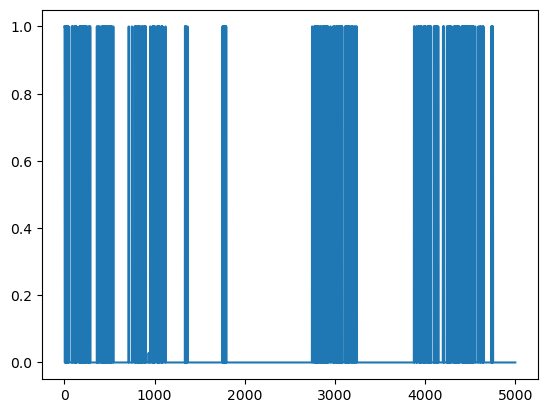

In [252]:
plt.plot(np.exp(accept_prob_list[1000:]))

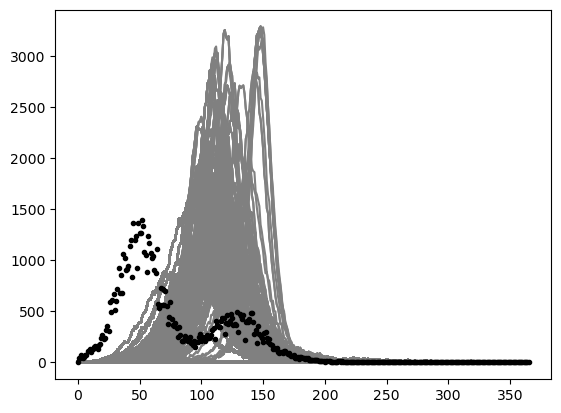

In [253]:
plt.plot(i[3000:,:].T, color='grey')
plt.plot(data.i, '.', color='black', label='obs')

In [254]:
from random import choices

ppc = choices(trace, k=1000)

i_ppc_list = []
for theta in ppc:
    S0 = N - theta['I0']
    _, _, _, i = integrate(t_I=true_params['t_I'], N=true_params['N'], S0=S0, n_t=true_params['n_t'], **theta)
    i_ppc_list.append(i)

In [255]:
i_ppc = np.array(i_ppc_list)

In [256]:
i_ppc = i_ppc[:,1:]

/opt/anaconda3/envs/rt-estimation/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


[Text(0.5, 1.0, 'Posterior Predictive HDI SIR Model')]

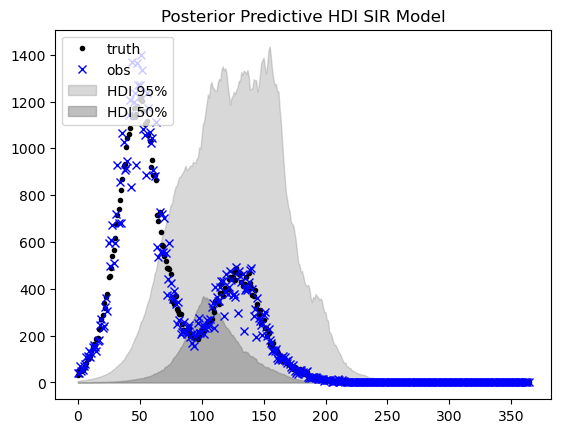

In [257]:

fig, ax = plt.subplots()
t = range(n_t)

ax.plot(t, data.i_true[1:], '.', label="truth", color='black')
ax.plot(t, data.i[1:], 'x', label="obs", color='blue')

az.plot_hdi(
    x=t,
    y=i_ppc,
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=t,
    y=i_ppc,
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive HDI SIR Model")


In [258]:
i_ppc.shape

(1000, 365)

In [259]:
ci_95 = az.hdi(i_ppc, hdi_prob=0.95)
ci_50 = az.hdi(i_ppc, hdi_prob=0.5)
prop_95 = np.mean((ci_95[:, 0] <= data.i[1:]) & (data.i[1:] <= ci_95[:, 1]))
prop_50 = np.mean((ci_50[:, 0] <= data.i[1:]) & (data.i[1:] <= ci_50[:, 1]))
print(f"Percent of observations in 95% CI {round(prop_95*100, 2)}%")
print(f"Percent of observations in 50% CI {round(prop_50*100, 2)}%")

Percent of observations in 95% CI 71.23%
Percent of observations in 50% CI 22.19%


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_13134/641099653.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ci_95 = az.hdi(i_ppc, hdi_prob=0.95)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_13134/641099653.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ci_50 = az.hdi(i_ppc, hdi_prob=0.5)


### Figure out how the hell PyMC is calculating likelihoods

In [25]:


loglike_prob(i)

-790298.5758905652

In [133]:
import pymc as pm
import pytensor
import pytensor.tensor as pt

def compute_loglikelihood(i):
    t = np.arange(0, 365)
    coords = {'day':t}
    with pm.Model(coords=coords) as likelihood_sampler:
        normal = pm.MvNormal(
            "like_normal",
            mu=i[1:],
            cov=np.diag((1+0.2*i[1:])**2),
            dims="day"
        )
    return likelihood_sampler.compile_logp()({'like_normal': data.i[1:]})

In [134]:
compute_loglikelihood(i)

array(-3400296.51916413)

In [135]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.MvNormal(
        "like_normal",
        mu=i[1:],
        cov=np.diag((1+0.2*i[1:])**2),
        dims="day"
    )

In [136]:
pm.logp(normal, data.i[1:]).eval()

array(-3400296.51916413)

Things are consistent between PyMC and my janky code when using `pm.MvNormal`

In [137]:
def like_prob_univariate(i, data=data.i):
    prob = norm(loc=i[1:], scale=(1+0.2*i[1:])).logpdf(data[1:])
    return prob

In [138]:
np.sum(like_prob_univariate(i))

-3400296.5191641324

In [139]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.Normal(
        "like_normal",
        mu=i[1:],
        sigma=np.abs(1+0.2*i[1:]),
        dims="day"
    )

In [140]:
np.sum(pm.logp(normal, data.i[1:]).eval())

-3400296.5191641324